# Workflow of the rim-detection algorithm
I would like to have a graphical plot showing all the different steps in the algorithm.

I was thinking at 5 rows and 3 columns graph with (a) crater center; (b) crater center with a 4 radii envelope around the crater and the clipped DEM, (c) the sampling of cross-sections pixel wise with non-overlapping, (d) crater with the 2.0 and 3.0 radii radius circle, (e) show one cross section before and after the first detrending, the actual cross section can be highlight in red in (c), (f) detection of global maxima, (g) second detrending with the plane going through 0.9 and 1.1 radii, (h) showing the result of this detrending for one cross section, (i) finding local + global maxima, (j) finding global maxima and local maxima, (k) generating rim composite, (l) redoing everything after adjusting for crater center and crater diameter, (m that takes three spots). I could actually make a script plotting all of these things automatically (with the help of rasterio and ++). So I need

- 1) coordinates of the crater center
- 2) envelope at 4R or 8R + clipped DEM
- 3) circle at a distance of 2R and 3R and all the values in between
- 4) plane fitted through these points (3D is maybe a bit too complicated)? Otherwise show cross sections before and after for and W-E and N-S transects. 
- 5) detection of global maxima
- 6) detection of local maximas
- 7) generation of a rim composite based on locations of global and local maximas
- 8) an ellipse is fitted (or a circle, check) through the detected rim and the centre of the crater is re-calculated, steps (3) to (7) are re-conducted. A second detrending steps is conducted after the first one (between 0.9 and 1.1 R)

In [1]:
from pathlib import Path
from rasterio.plot import reshape_as_raster, reshape_as_image

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import rasterio as rio

In [2]:
sys.path.append("/home/nilscp/GIT/crater_morphometry/rim_detection")
sys.path.append("/home/nilscp/GIT/crater_morphometry/preprocessing")
sys.path.append("/home/nilscp/GIT/crater_morphometry")

import rim_detection
import geomorphometry

In [3]:
import scipy

def detrending(crater_radius,
               from_scaled_crater_radius, scaled_crater_radius_end,
               elevations, 
               dem_resolution, 
               xmesh, ymesh, 
               height_crater_center_px, width_crater_center_px, 
               filterMedianStd):
    
    '''
    Routine to fetch all the pixel values between SCALED_crater_radius_START and 
    SCALED_crater_radius_END from the crater centre (e.g., between 2.0 R and 3.0 R
    for detrending in a regional context and 0.9 and 1.1 for detrending
    assymetries along ) 

    Parameters
    ----------
    crater_radius : float
        crater crater_radius in the unit of the proj. coordinate system (e.g., meters).
    from_scaled_crater_radius : float
        Distance (scaled with the crater_radius of the crater diameter) from which the
        detrending step will be conducted. 
    scaled_crater_radius_end : float
        Distance (scaled with the crater_radius of the crater diameter) up to which the
        detrending step will be conducted. 
    elevations : numpy array
        Numpy array containg elevations (either original or detrended values).
    dem_resolution : float
        resolution of the DEM in meters.
    xmesh : numpy array
        mesh grid with the same dimension as the elevations.
    ymesh : numpy array
        mesh grid with the same dimension as the elevations.
    height_crater_center_px : int
        centre of the crater in pixel coordinates.
    width_crater_center_px : int
        centre of the crater in pixel coordinates.
    filterMedianStd : boolean
        if True, values above the median of the elevation + one standard dev
        and below the median of the elevation - one standard dev are discarded.
        This allow 

    Returns
    -------
    detrended_elevation : numpy array 
        Detrended elevations between the specified from_scaled_crater_radius and 
        .
        
    Suggestions for improvements
    -------
    - I am sure the selection could be made in a much more smooth way. Check
    https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle.
    This would be make this script much smaller and would avoid some unnecessary
    looping. 
    - Error message if, for some reasons, the from_scaled_crater_radius and scaled_crater_radius_end
    result in the fetching of elevations values outside of the mapped area.

    '''
    # in map coordinates       
    x2, y2 = rim_detection.xy_circle((from_scaled_crater_radius*crater_radius) / dem_resolution, 
                       height_crater_center_px, width_crater_center_px)
    
    x3, y3 = rim_detection.xy_circle((scaled_crater_radius_end*crater_radius) / dem_resolution, 
                       height_crater_center_px, width_crater_center_px)
              
    (x2, y2, x3, y3) = (np.round(x2).astype('int'), np.round(y2).astype('int'),
                        np.round(x3).astype('int'), np.round(y3).astype('int'))

    # number of values along each cross section
    # sampled at two times the dem resolution
    n_points_along_cs = np.int((crater_radius / dem_resolution) * 2.0)
    
    # empty array
    y_disk_seletion_px = []
    x_disk_seletion_px = []
    
    # Looping through all the x-coordinates of the circle located at 2R
    for i in range(len(x2)):

        # the starting coordinates move all the time and correspond to the 
        # boundary of the 2R circle
        x_cs_start = x2[i]
        y_cs_start = y2[i]
        
        # the end coordinates correspond to the boundary of the 3R circle
        x_cs_end = x3[i]
        y_cs_end = y3[i]
                
        # the distance is calculated, should be equal to two times the crater_radius
        (x_coord_cs, y_coord_cs) = (np.linspace(x_cs_start, x_cs_end, n_points_along_cs), 
                        np.linspace(y_cs_start, y_cs_end, n_points_along_cs))
        
        # only integer here
        (x_coord_cs, y_coord_cs) = (np.round(x_coord_cs).astype('int'), 
                                    np.round(y_coord_cs).astype('int'))
        
        #need to get rid of repetitions
        rep = np.zeros((len(x_coord_cs),2))
        rep[:,0] = x_coord_cs
        rep[:,1] = y_coord_cs
        __, index = np.unique(["{}{}".format(ix, j) for ix,j in rep], 
                              return_index=True)
        
        for i in index:
            x_disk_seletion_px.append(x_coord_cs[i])
            y_disk_seletion_px.append(y_coord_cs[i])
    
    
    # these correspond to all coordinates between the slice of 2R and 3R                
    x_disk_seletion_px = np.array(x_disk_seletion_px)
    y_disk_seletion_px = np.array(y_disk_seletion_px)
           
    # elevations are extracted for the map coordinates
    z = elevations[x_disk_seletion_px,y_disk_seletion_px]
 
    # and x- and y-coordinates in meters (this is correct now) # weird
    x_disk_seletion = xmesh[x_disk_seletion_px,y_disk_seletion_px]
    y_disk_seletion = ymesh[x_disk_seletion_px,y_disk_seletion_px]
    
    return (x_disk_seletion, y_disk_seletion, z)


def detect_maximum_elevations(xmesh, ymesh, 
                              height_crater_center_px, width_crater_center_px, 
                              elevations, crater_radius, dem_resolution):
    '''
    

    Parameters
    ----------
    xmesh : TYPE
        DESCRIPTION.
    ymesh : TYPE
        DESCRIPTION.
    height_crater_center_px : TYPE
        DESCRIPTION.
    width_crater_center_px : TYPE
        DESCRIPTION.
    elevations : TYPE
        DESCRIPTION.
    crater_radius : TYPE
        DESCRIPTION.
    dem_resolution : TYPE
        DESCRIPTION.

    Returns
    -------
    col_coord_ME : TYPE
        DESCRIPTION.
    row_coord_ME : TYPE
        DESCRIPTION.
    col_px_ME : TYPE
        DESCRIPTION.
    row_px_ME : TYPE
        DESCRIPTION.
    elev_ME : TYPE
        DESCRIPTION.
    prof_ME : TYPE
        DESCRIPTION.

    '''
    
   
    # 2R circles pixel coordinates x2, y2
    x2, y2 = rim_detection.xy_circle((2.0*crater_radius) / dem_resolution, 
                         height_crater_center_px, width_crater_center_px)
    
    # real values x2, y2
    (x2, y2) = (np.round(x2).astype('int'), np.round(y2).astype('int'))
                    
    # we define the maximum elevation variables   
    (col_coord_ME, row_coord_ME, 
     col_px_ME, row_px_ME, 
     elev_ME) = [np.ones(len(x2)) for _ in range(5)]
    
    # profile ID
    prof_ME = np.arange(0,512)
    
    # samples at half the dem_resolution 
    n_points_along_cs = np.int(np.ceil(2.0*crater_radius/dem_resolution)*2.0)
    
    # set arrays equal to nan
    [array.fill(np.nan) for array in 
    [col_coord_ME, row_coord_ME, col_px_ME, row_px_ME, elev_ME]]
    
    
    # empty array
    cols_disk_seletion_px = []
    rows_disk_seletion_px = []
    prof = []
        
    # generate cross sections between the centre of the crater and the 2.0R
    # circle pixel coordinates
    for ix in range(len(x2)):

        # find the pixel coordinates 
        ncol = x2[ix]
        nrow = y2[ix]
                
        # the distance is calculated, should be equal to two times the crater_radius
        (cols, rows) = (np.linspace(height_crater_center_px, ncol, n_points_along_cs),
        np.linspace(width_crater_center_px, nrow, n_points_along_cs))
        
        # Extract the values along the line, using cubic interpolation and the 
        # map coordinates
        z = scipy.ndimage.map_coordinates(elevations, np.vstack((cols,rows)))
        
        cols_disk_seletion_px.append(cols)
        rows_disk_seletion_px.append(rows)
        prof.append([ix] * len(cols))
        
    # only integer here
    (cols_disk_seletion_px, rows_disk_seletion_px) = (np.round(cols_disk_seletion_px).astype('int'), 
                                    np.round(rows_disk_seletion_px).astype('int'))
                
    # and x- and y-coordinates in meters (this is correct now) # weird
    width_seletion = ymesh[cols_disk_seletion_px,rows_disk_seletion_px]
    height_seletion = xmesh[cols_disk_seletion_px,rows_disk_seletion_px]
    
    return (height_seletion, width_seletion, prof)

### Need to get the map proj. from the rayed crater layer (for later, when I will export the points to QGIS to make nice plots)
But also the crater diameter so that is much easier

In [4]:
df = gpd.read_file("/home/nilscp/GIT/crater_morphometry/data/rayed_craters/rayed_craters.shp")

In [5]:
df.crs

<Projected CRS: PROJCS["SimpleCylindrical_Moon",GEOGCS["GCS_Moon", ...>
Name: SimpleCylindrical_Moon
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Equidistant Cylindrical
Datum: D_Moon
- Ellipsoid: Moon
- Prime Meridian: Reference_Meridian

### Selection of Linne crater

In [6]:
# some information related to the crater008
crater_id = 'crater0173'
i = 173

crater_dem = Path('/home/nilscp/tmp/crater/' + crater_id + '.tif')
scaling_factor = 0.5
dem_resolution = 59.22529380000000288
crater_radius = (df.Diam_km.iloc[i]*1000.0) / 2.0

### To read the raster with rasterio

In [7]:
with rio.open(crater_dem) as src:
    array = src.read()
    meta = src.profile
    
reshaped_array = reshape_as_image(array)[:,:,0]
reshaped_array.shape, array.shape

((313, 312), (1, 313, 312))

In [8]:
meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 312, 'height': 313, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Equirectangular Moon",GEOGCS["GCS_Moon",DATUM["D_Moon",SPHEROID["Moon_localRadius",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(59.2252938, 0.0, 348600.0795678003,
       0.0, -59.2252938, 850475.2188810001), 'tiled': False, 'interleave': 'band'}

### upper left coordinates (origin) of the raster

In [9]:
x_origin = meta['transform'][2]
y_origin = meta['transform'][5]

x_origin, y_origin

(348600.0795678003, 850475.2188810001)

### Get the centre of the crater

In [10]:
# infer dem resolution from the crater dem 
dem_resolution = meta['transform'][0]

# height scaling factor for the SLDEM2015
z = reshaped_array * scaling_factor

# we would like to have a square array so we take the min
min_of_shape = np.min(z.shape)
z_square = z[:min_of_shape, :min_of_shape]

x_y = np.linspace(0,(min_of_shape-1)*dem_resolution,min_of_shape)
x_y_center = np.linspace(dem_resolution/2.0, (dem_resolution/2.0) + 
                         ((min_of_shape-1)*dem_resolution), min_of_shape)

# mix up, so actually x is equivalent to the width and columns
height_mesh, width_mesh = np.meshgrid(x_y, x_y, indexing='ij') 
height_mesh_center, width_mesh_center = np.meshgrid(x_y_center, x_y_center, indexing='ij') 

(height_px, width_px) = np.meshgrid(np.arange(min_of_shape), np.arange(min_of_shape), indexing='ij') 

# centre of the map
x_center_px = int(min_of_shape / 2)
y_center_px = int(min_of_shape / 2)

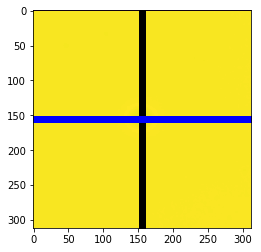

In [11]:
plt.imshow(z_square)
plt.plot(height_px[y_center_px,:], width_px[y_center_px,:], "ko") #W-E
plt.plot(height_px[:,x_center_px], width_px[:,x_center_px], "bo") #N-S

### First detrending + detection of maximum and local elevations (+ break in slope changes)

In [12]:
# cols and rows are here mixed up.... should be first row (height) and then column (width)
((z_detrended), (height_coord_ME, width_coord_ME, height_px_ME, width_px_ME, elev_ME, prof_ME,
            height_coord_LE, width_coord_LE, height_px_LE, width_px_LE, elev_LE, prof_LE,
            height_coord_BS, width_coord_BS, height_px_BS, width_px_BS, elev_BS, prof_BS)) = rim_detection.run(crater_dem, crater_radius, scaling_factor)

/home/nilscp/GIT/crater_morphometry/rim_detection/rim_detection.py:514: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  be4stat = np.linalg.lstsq(sbe4,zbe4)[0]
/home/nilscp/GIT/crater_morphometry/rim_detection/rim_detection.py:515: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  aftstat = np.linalg.lstsq(saft,zaft)[0]


Let's try to export some of this data so that we can make plots in QGIS (Note that as the origin is from the top left, the slicing of the dem to obtain a square dem should not have any affect)

### Let's export the centre of the crater

In [13]:
x_y[y_center_px]

9239.145832799999

In [14]:
x_y[x_center_px]

9239.145832799999

In [15]:
y_center = y_origin - x_y[y_center_px]
x_center = x_origin + x_y[x_center_px]

df_xy_center = pd.DataFrame(
    {'prof': [0],
     'x': [x_center],
     'y': [y_center]})

gdf_center = gpd.GeoDataFrame(
    df_xy_center.prof, geometry=gpd.points_from_xy(df_xy_center.x, df_xy_center.y))

gdf_center.crs = df.crs
gdf_center.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_centre_crater.shp")

### Export two and three times the scaled radius

In [52]:
height_mesh

array([[    0.       ,     0.       ,     0.       , ...,     0.       ,
            0.       ,     0.       ],
       [   59.2252938,    59.2252938,    59.2252938, ...,    59.2252938,
           59.2252938,    59.2252938],
       [  118.4505876,   118.4505876,   118.4505876, ...,   118.4505876,
          118.4505876,   118.4505876],
       ...,
       [18300.6157842, 18300.6157842, 18300.6157842, ..., 18300.6157842,
        18300.6157842, 18300.6157842],
       [18359.841078 , 18359.841078 , 18359.841078 , ..., 18359.841078 ,
        18359.841078 , 18359.841078 ],
       [18419.0663718, 18419.0663718, 18419.0663718, ..., 18419.0663718,
        18419.0663718, 18419.0663718]])

In [16]:
(x_disk_seletion, y_disk_seletion, z_disk_seletion,  z2R3R) = rim_detection.detrending(crater_radius,
               2.0, 3.0,
               z_square, 
               dem_resolution, 
               height_mesh, width_mesh, 
               y_center_px, x_center_px, 
               True, debugging=True)

In [17]:
x_disk_seletion.shape, y_disk_seletion.shape, z2R3R.shape

((11352,), (11352,), (312, 312))

In [18]:
# again big mess between x and y
y_2R3R = y_origin - x_disk_seletion
x_2R3R = x_origin + y_disk_seletion

df_xy_2R3R = pd.DataFrame(
    {'z': list(z_disk_seletion),
     'x': list(x_2R3R),
     'y': list(y_2R3R)})

gdf_2R3R = gpd.GeoDataFrame(
    df_xy_2R3R.z, geometry=gpd.points_from_xy(df_xy_2R3R.x, df_xy_2R3R.y))

gdf_2R3R.crs = df.crs
gdf_2R3R.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_Nov2020_detrending_2R3R.shp")

### Export all the cross sections (with the profile ID so that I can show it in QGIS)

In [117]:
(cs_heights_list, cs_widths_list, cs_z_list, cs_prof_list,
                height_coord_ME, width_coord_ME, height_px_ME, width_px_ME, elev_ME, prof_ME) = rim_detection.detect_maximum_elevations(height_mesh, width_mesh, 
                                 y_center_px, x_center_px, 
                                 z_detrended, crater_radius, dem_resolution, debugging=True)

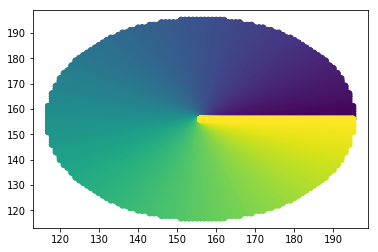

In [20]:
plt.scatter(cs_heights_list, cs_widths_list, c = cs_prof_list)

In [120]:
prof_cs = [np.array(x) for x in cs_prof_list]
prof_cs = np.array(prof_cs).flatten()
height_cs = np.array(cs_heights_list).flatten()
width_cs = np.array(cs_widths_list).flatten()
#z_cs= np.array(cs_z_list).flatten()

In [121]:
y_cs = y_origin - (height_cs *dem_resolution)
x_cs = x_origin + (width_cs * dem_resolution)

df_cs = pd.DataFrame(
    {'prof': list(prof_cs),
     'x': list(x_cs),
     'y': list(y_cs)})
     #'z': list(z_cs)})

gdf_cs = gpd.GeoDataFrame(
    df_cs.prof, geometry=gpd.points_from_xy(df_cs.x, df_cs.y)) #df_cs.z, 

gdf_cs.crs = df.crs
gdf_cs.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_csNov.shp")

### Let's export the maximum elevation detected

In [27]:
y_ME = y_origin - height_coord_ME # these are the values that should be given as height_coord_ME
x_ME = x_origin + width_coord_ME  # these are the values that should be given as width_coord_ME

df_xy = pd.DataFrame(
    {'prof': list(prof_ME),
     'x': list(x_ME),
     'y': list(y_ME)})

gdf = gpd.GeoDataFrame(
    df_xy.prof, geometry=gpd.points_from_xy(df_xy.x, df_xy.y))

gdf.crs = df.crs
gdf.to_file("/home/nilscp/tmp/step_by_step/"  + crater_id + "_ME_first_detrendNov.shp")

#### Let's export the local elevations

In [28]:
y_LE = y_origin - height_coord_LE
x_LE = x_origin + width_coord_LE

df_xy_LE = pd.DataFrame(
    {'prof': list(prof_LE),
     'x': list(x_LE),
     'y': list(y_LE)})

gdf_LE = gpd.GeoDataFrame(
    df_xy_LE.prof, geometry=gpd.points_from_xy(df_xy_LE.x, df_xy_LE.y))

gdf_LE.crs = df.crs
gdf_LE.to_file("/home/nilscp/tmp/step_by_step/"  + crater_id + "_LE_first_detrendNov.shp")

#### Let's export the change in slopes

In [29]:
y_BS = y_origin - height_coord_BS
x_BS = x_origin + width_coord_BS

df_xy_BS = pd.DataFrame(
    {'prof': list(prof_BS),
     'x': list(x_BS),
     'y': list(y_BS)})

gdf_BS = gpd.GeoDataFrame(
    df_xy_BS.prof, geometry=gpd.points_from_xy(df_xy_BS.x, df_xy_BS.y))

gdf_BS.crs = df.crs
gdf_BS.to_file("/home/nilscp/tmp/step_by_step/"  + crater_id + "_BS_first_detrendNov.shp")

### Let's make a few plots to get an idea of how well the detrending has been performing

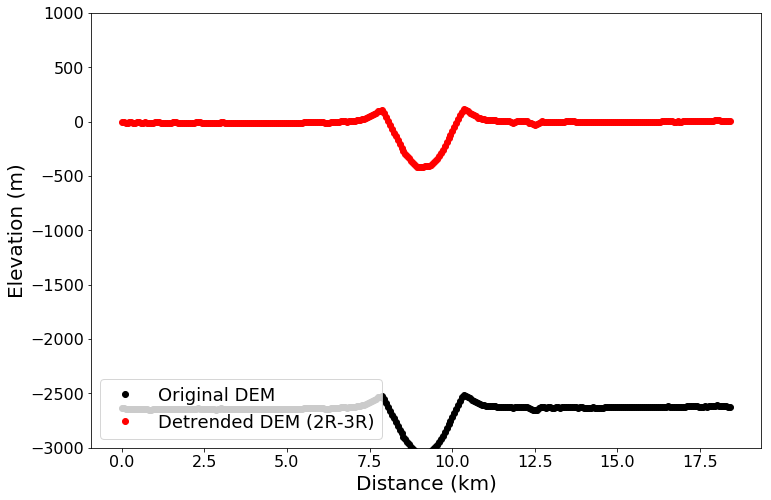

In [30]:
plt.figure(figsize=(12,8))

# W-E profile
plt.plot(np.arange(len(z_square[y_center_px,:])) * dem_resolution / 1000.0, z_square[y_center_px,:],"ko", label = 'Original DEM')
plt.plot(np.arange(len(z_detrended[y_center_px,:])) * dem_resolution / 1000.0, z_detrended[y_center_px,:],"ro", label = 'Detrended DEM (2R-3R)')
plt.ylim((-3000, 1000))
plt.legend(loc='lower left', fontsize = 18)
plt.xlabel('Distance (km)', fontsize = 20)
plt.ylabel('Elevation (m)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)

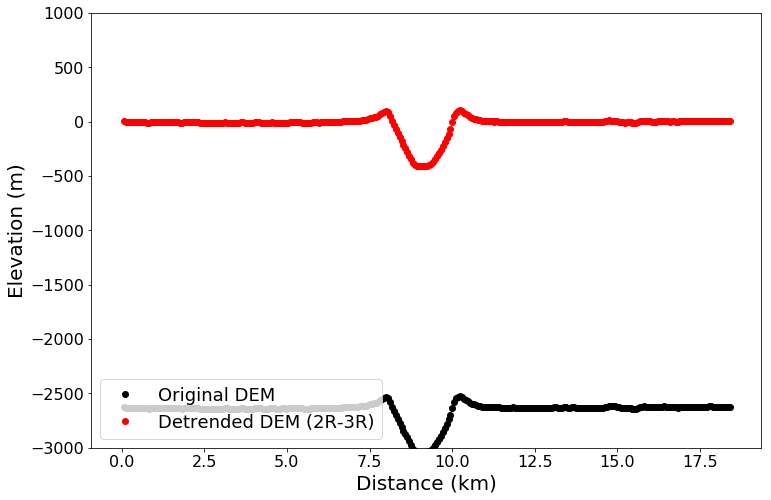

In [31]:
plt.figure(figsize=(12,8))

# N-S profile
plt.plot(np.arange(len(z_square[:,y_center_px])) * dem_resolution / 1000.0, z_square[:,y_center_px],"ko", label = 'Original DEM')
plt.plot(np.arange(len(z_detrended[:,y_center_px])) * dem_resolution / 1000.0, z_detrended[:,y_center_px],"ro", label = 'Detrended DEM (2R-3R)')
plt.ylim((-3000, 1000))
plt.legend(loc='lower left', fontsize = 18)
plt.xlabel('Distance (km)', fontsize = 20)
plt.ylabel('Elevation (m)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)

### Could eventually make a 3D plot with k3D...
Or a difference in DEM (before and after detrending) to have a good understanding. If I want to save the new detrended DEM...

In [ ]:
meta

In [ ]:
meta_new_DEM = meta.copy()

In [ ]:
meta_new_DEM['width'] = int(min_of_shape)
meta_new_DEM['height'] = int(min_of_shape)
meta_new_DEM['dtype'] = 'float64'

In [ ]:
np.shape(z_detrended)

In [ ]:
z_detrended_reshaped = np.reshape(z_detrended, (int(min_of_shape),int(min_of_shape),1))
z_square_reshaped = np.reshape(z_square, (int(min_of_shape),int(min_of_shape),1))

In [ ]:
destination = "/home/nilscp/tmp/step_by_step/" + crater_id + "_detrended.tif"

with rio.open(destination, 'w', **meta_new_DEM) as ds:

    # reshape to rasterio raster format
    ds.write(reshape_as_raster(z_detrended_reshaped))
    
destination_sq = "/home/nilscp/tmp/step_by_step/" + crater_id + "_square.tif"

with rio.open(destination_sq, 'w', **meta_new_DEM) as ds:

    # reshape to rasterio raster format
    ds.write(reshape_as_raster(z_square_reshaped))

### Stiching of a rim composite

In [32]:
# Maximum allowed radial discontinuity Drad (I should convert these values in cells)
Drad = 0.1 * crater_radius

# Distance of interest (searching distance)
Dint = 0.05 * crater_radius


OptRims, Omegas, gap, maxradf = rim_detection.rim_composite(y_ME, x_ME, height_px_ME, width_px_ME, elev_ME, prof_ME, 
                  y_LE, x_LE, height_px_LE, width_px_LE, elev_LE, prof_LE,
                  height_mesh, width_mesh, y_center_px, x_center_px, 
                  Drad, Dint)


#rim_composite(height_coord_ME, width_coord_ME, height_px_ME, width_px_ME, elev_ME, profile_ME, 
#                  height_coord_LE, width_coord_LE, height_px_LE, width_px_LE, elev_LE, profile_LE,
#                  height_mesh, width_mesh, height_crater_center_px, width_crater_center_px, 
#                  maximum_shift_ME, maximum_shift_LE)

now have the 16 cross sections (In this case a maximum elevation has been found everywhere, so that local elevation values are not used). The 16 cross sections are similar. 

In [33]:
np.shape(OptRims), np.shape(OptRims)[0] 

((1, 5, 512), 1)

In [ ]:
#for i in range(16):
#    plt.plot(OptRims[i][0,:] + (i*10000), OptRims[i][1,:] ,"o") # x and y

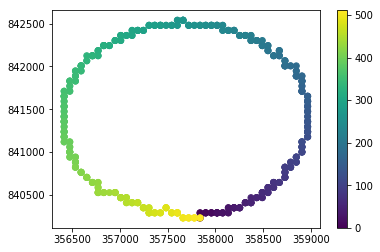

In [34]:
plt.scatter(OptRims[0][1,:][OptRims[0][1,:] != 0], OptRims[0][0,:][OptRims[0][0,:] != 0], c = OptRims[0][-2,:][OptRims[0][1,:] != 0]) # x (width) & y (height) with the name of the profile, need to get rid of zeros
plt.colorbar()


# xarcgis[~np.isnan(xarcgis)]

In [ ]:
plt.scatter(OptRims[1][1,:][OptRims[1][1,:] != 0], OptRims[1][0,:][OptRims[1][0,:] != 0], c = OptRims[1][-3,:][OptRims[1][1,:] != 0]) # x and y with the elevation 
plt.colorbar()

In [ ]:
plt.scatter(OptRims[2][1,:][OptRims[2][1,:] != 0], OptRims[2][0,:][OptRims[2][0,:] != 0], c = OptRims[2][-3,:][OptRims[2][1,:] != 0]) # x and y with the elevation 
plt.colorbar()

In [ ]:
plt.scatter(OptRims[3][1,:][OptRims[3][1,:] != 0], OptRims[3][0,:][OptRims[3][0,:] != 0], c = OptRims[3][-3,:][OptRims[3][1,:] != 0]) # x and y with the elevation 
plt.colorbar()

In [ ]:
plt.scatter(OptRims[4][1,:][OptRims[4][1,:] != 0], OptRims[4][0,:][OptRims[4][0,:] != 0], c = OptRims[4][-3,:][OptRims[4][1,:] != 0]) # x and y with the elevation 
plt.colorbar()

### Selection of the best rim composite 
It only make uses of omegas (which are the number of cross section profiles where the maximum elevations failed the selection criteria (within 0.1D of the previous

In [35]:
for i in range(np.shape(OptRims)[0]):
    a = np.mean(maxradf[i]) + (0.5*Omegas[i])
    if i == 0:
        b = a
        c = i
    else:
        if a < b:
            b = a
            c = i

/home/nilscp/anaconda3/envs/remoteSensing/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nilscp/anaconda3/envs/remoteSensing/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### I would like to extract several rims composite for an example (and the final selection)

### Fitting of a circle through the best rim composite and re-adjusting ot the centre of the crater

In [36]:
height_arcgis = np.array(OptRims[c][0,:])
height_arcgis = height_arcgis[np.nonzero(height_arcgis)] 

width_arcgis = np.array(OptRims[c][1,:])
width_arcgis = width_arcgis[np.nonzero(width_arcgis)]

zarcgis = np.array(OptRims[c][2,:])
zarcgis = zarcgis[np.nonzero(height_arcgis)]

profgis = np.array(OptRims[c][3,:])
profgis = profgis[np.nonzero(height_arcgis)]

flaggis = np.array(OptRims[c][4,:])
flaggis = flaggis[np.nonzero(height_arcgis)]

In [37]:
df_xy_rim_composite = pd.DataFrame(
    {'prof': list(profgis),
     'x': list(width_arcgis),
     'y': list(height_arcgis)})

gdf_rim_composite = gpd.GeoDataFrame(
    df_xy_rim_composite.prof, geometry=gpd.points_from_xy(df_xy_rim_composite.x, df_xy_rim_composite.y))

gdf_rim_composite.crs = df.crs
gdf_rim_composite.to_file("/home/nilscp/tmp/step_by_step/"  + crater_id + "_rim_compositeNov.shp")

In [38]:
xnewcenter, ynewcenter, rnew, residu = geomorphometry.leastsq_circle(width_arcgis,height_arcgis)

In [39]:
xnewcenter, ynewcenter, rnew, x_center, y_center

(357692.4388838661,
 841389.9938935648,
 1198.8310282644534,
 357839.2254006003,
 841236.0730482001)

### Save location of the new crater centre

In [40]:
df_xy_new_center = pd.DataFrame(
    {'prof': [0],
     'x': [xnewcenter],
     'y': [ynewcenter]})

gdf_new_center = gpd.GeoDataFrame(
    df_xy_new_center.prof, geometry=gpd.points_from_xy(df_xy_new_center.x, df_xy_new_center.y))

gdf_new_center.crs = df.crs
gdf_new_center.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_new_centre_craterNov.shp")

### Rerun everything with the new location of the crater (including two detrending now)

In [50]:
x_new_center_px, y_new_center_px = int(round((xnewcenter - x_origin) / dem_resolution)), int(round((y_origin - ynewcenter) / dem_resolution))

In [53]:
(x_disk_seletion2, y_disk_seletion2, z_disk_seletion2,  z2R3R2) = rim_detection.detrending(rnew,
               2.0, 3.0,
               z_square, 
               dem_resolution, 
               height_mesh, width_mesh, 
               y_new_center_px, x_new_center_px, 
               True, debugging=True)


(x_disk_seletion3, y_disk_seletion3, z_disk_seletion3,  z2R3R3) = rim_detection.detrending(rnew,
               0.9, 1.1,
               z2R3R2, 
               dem_resolution, 
               height_mesh, width_mesh, 
               y_new_center_px, x_new_center_px, 
               True, debugging=True)

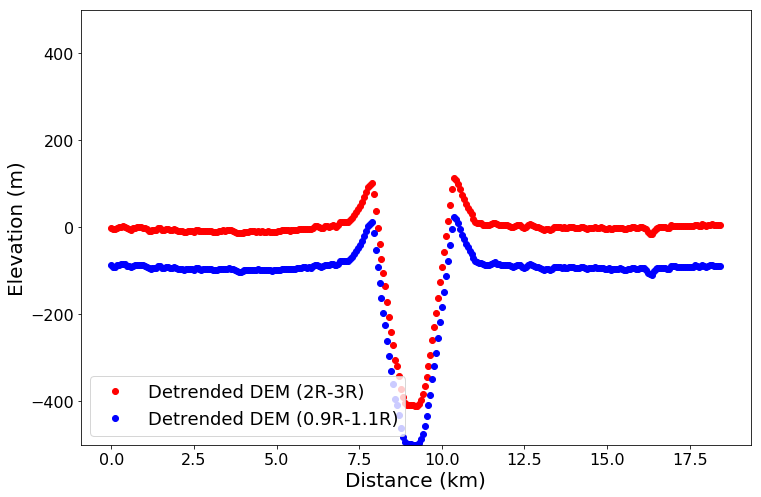

In [57]:
plt.figure(figsize=(12,8))

# W-E profile
#plt.plot(np.arange(len(z_square[y_new_center_px,:])) * dem_resolution / 1000.0, z_square[y_new_center_px,:],"ko", label = 'Original DEM')
plt.plot(np.arange(len(z2R3R2[y_new_center_px,:])) * dem_resolution / 1000.0, z2R3R2[y_new_center_px,:],"ro", label = 'Detrended DEM (2R-3R)')
plt.plot(np.arange(len(z2R3R3[y_new_center_px,:])) * dem_resolution / 1000.0, z2R3R3[y_new_center_px,:],"bo", label = 'Detrended DEM (0.9R-1.1R)')
plt.ylim((-500, 500))
plt.legend(loc='lower left', fontsize = 18)
plt.xlabel('Distance (km)', fontsize = 20)
plt.ylabel('Elevation (m)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)

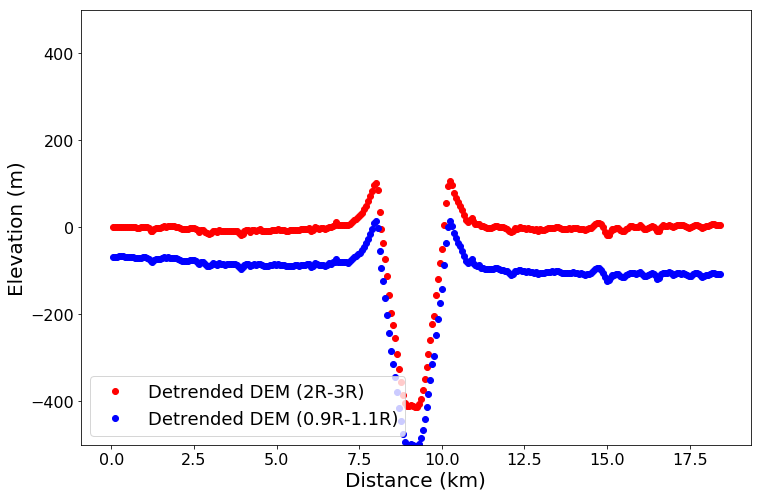

In [58]:
plt.figure(figsize=(12,8))

# W-E profile
#plt.plot(np.arange(len(z_square[:,y_new_center_px])) * dem_resolution / 1000.0, z_square[:,y_new_center_px],"ko", label = 'Original DEM')
plt.plot(np.arange(len(z2R3R2[:,y_new_center_px])) * dem_resolution / 1000.0, z2R3R2[:,y_new_center_px],"ro", label = 'Detrended DEM (2R-3R)')
plt.plot(np.arange(len(z2R3R3[:,y_new_center_px])) * dem_resolution / 1000.0, z2R3R3[:,y_new_center_px],"bo", label = 'Detrended DEM (0.9R-1.1R)')
plt.ylim((-500, 500))
plt.legend(loc='lower left', fontsize = 18)
plt.xlabel('Distance (km)', fontsize = 20)
plt.ylabel('Elevation (m)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [59]:
# again big mess between x and y
y_2R3R_second_detrending = y_origin - x_disk_seletion2
x_2R3R_second_detrending = x_origin + y_disk_seletion2

df_xy_2R3R = pd.DataFrame(
    {'z': list(z_disk_seletion2),
     'x': list(x_2R3R_second_detrending),
     'y': list(y_2R3R_second_detrending)})

gdf_2R3R = gpd.GeoDataFrame(
    df_xy_2R3R.z, geometry=gpd.points_from_xy(df_xy_2R3R.x, df_xy_2R3R.y))

gdf_2R3R.crs = df.crs
gdf_2R3R.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_Nov2020_second_detrending_2R3R.shp")

In [60]:
# again big mess between x and y
y_2R3R_second_detrending = y_origin - x_disk_seletion3
x_2R3R_second_detrending = x_origin + y_disk_seletion3

df_xy_2R3R = pd.DataFrame(
    {'z': list(z_disk_seletion3),
     'x': list(x_2R3R_second_detrending),
     'y': list(y_2R3R_second_detrending)})

gdf_2R3R = gpd.GeoDataFrame(
    df_xy_2R3R.z, geometry=gpd.points_from_xy(df_xy_2R3R.x, df_xy_2R3R.y))

gdf_2R3R.crs = df.crs
gdf_2R3R.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_Nov2020_second_detrending_1R.shp")

#### Radial cross sections

In [61]:
(cs_heights_list2, cs_widths_list2, cs_z_list2, cs_prof_list2,
                height_coord_ME, width_coord_ME, height_px_ME, width_px_ME, elev_ME, prof_ME) = rim_detection.detect_maximum_elevations(height_mesh, width_mesh, 
                                 y_new_center_px, x_new_center_px, 
                                 z2R3R3, rnew, dem_resolution, debugging=True)

In [110]:
cs_prof_list2_mod = [np.array(x) for x in cs_prof_list2]

In [112]:
prof_cs = np.array(cs_prof_list2_mod).flatten()
height_cs = np.array(cs_heights_list2).flatten()
width_cs = np.array(cs_widths_list2).flatten()
z_cs= np.array(cs_z_list2).flatten()

In [104]:
df_cs.z.shape, df_cs.prof.shape

((41984,), (41984,))

In [114]:
y_cs = y_origin - (height_cs *dem_resolution)
x_cs = x_origin + (width_cs * dem_resolution)

df_cs = pd.DataFrame(
    {'x': list(x_cs),
     'y': list(y_cs),
     'prof': list(prof_cs)})
     #'z': list(z_cs)})

gdf_cs = gpd.GeoDataFrame(
    df_cs.prof, geometry=gpd.points_from_xy(df_cs.x, df_cs.y)) #df_cs.z, 

gdf_cs.crs = df.crs
gdf_cs.to_file("/home/nilscp/tmp/step_by_step/" + crater_id + "_csNov_second_detrendingtest.shp")

In [46]:
x_center_px, y_center_px

(156, 156)

#### Get the px coordinates the closest to the new centers

#### Two detrending (between 2.0 and 3.0R  and 0.9 and 1.1R)

### Run the calculations from the cross sections